# Introducing a validation loss
SPINN model to solve Fisher KPP on bounded domain in 1D.

**This notebook aims at introducing the usage of a validation in** **jinns**

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\frac{\partial^2}{\partial x^2} u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x)), t\geq 0, x\in [0,l]\\
u(t,0)=u(t,l)=0,t\geq 0, \text{Dirichlet condition}\\
u(0,x)=u_0(x),x\in [0,l]
\end{cases}
$$

In all that follows, $r(x)$, $\gamma(x)$ et $D$ are considered constant.

For more details about this experiment, see also the notebook _Fisher KPP on bounded domain in 1D (PINN and SPINN)_


In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Float64 and GPU settings

In [22]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [23]:
import jinns


Import other dependencies

In [24]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


Create the neural network architecture for the PINN

Create the SPINN

In [25]:
d = 2
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r],
]
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [26]:
init_nn_params_spinn = u_spinn.init_params()

Create a DataGenerator object for the training data

In [27]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 2
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 5
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


## Set up the initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

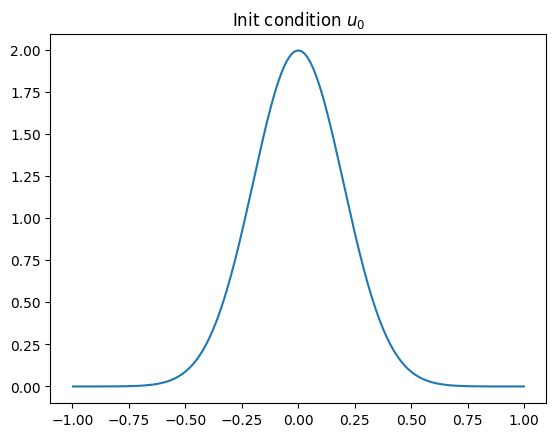

In [28]:
from jax.scipy.stats import norm
# true solution N(0,1)
sigma_init = 0.2 * jnp.ones((1))
mu_init = 0 * jnp.ones((1))

def u0(x):
    return jnp.squeeze(norm.pdf(x, loc=mu_init, scale=sigma_init))

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Model parameters

In [29]:
# Example III.29 is persistent with D = 1, r = 4,  g = 3
D = 1.
r = 4.
g = 3.
l = xmax - xmin
boundary_condition = "dirichlet"
omega_boundary_fun = lambda t, dx: 0 # cte func returning 0

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [30]:
init_params_spinn = {
    "nn_params":init_nn_params_spinn,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
}

## Loss construction

In [31]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax
)

Loss for the SPINN

In [32]:
loss_weights = {"dyn_loss":1, "initial_condition": 1 * Tmax, "boundary_loss":1 * Tmax}

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)

## Setting up the validation step

**Create a DataGenerator object for the validation data**: The same as for the train data but we do not want mini-batches over the validation dataset. We simply let the size of the batch be the total size of the dataset `omega_batch_size=n` and `temporal_batch_size=nt`.

In [33]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 1000
temporal_batch_size = 1000
omega_border_batch_size = 2 # Recall that the size here is irrelevant when the dimension of $\Omega$ is 1

Tmax = 5
key, subkey = random.split(key)
validation_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


The validation step can be very general. It consist is based around a function [ THAT WE HERE DEFINE XXXX ]

We here load a basic validation procedure provided by default in **jinns** (`eval_validation_loss_and_early_stopping`). This consists of evaluating the loss on the validation dataset and triggering (or not) an early stopping procedure.
We must also load and instanciate the corresponding NamedTuple of hyperparams for this validation strategy (`ValidationLossEarlyStoppingHyperparams`).

Note that the `call_every` hyperparameter which represents how often is the validation step called is an hyperparameter that is always required.

In [34]:
from jinns.validation import ValidationLoss
validation = ValidationLoss(
    loss = loss_spinn, # a deep copy of `loss_pinn` will be done internally
    validation_data = validation_data,
    validation_param_data = None,
    validation_obs_data = None,
    call_every=250,
    early_stopping=True,
    patience=10
)

print(validation.counter)


0.0


We set up the `validation` argument for the call to `solve()`. As stated by the doc, this argument consists in a tuple of 5 elements:

- validation_data: a DataGenerator of the same type of data for validation dataset for the collocation points. Can be None depending on the validation loss that is used
- validation_param_data: a DataGenerator of the same type of `param_data` for validation dataset for the collocation points. Can be None depending on the validation loss that is used                                
- validation_obs_data: a DataGenerator of the same type of `obs_data` for validation dataset for the collocation points. Can be None depending on the validation loss that is used                                
- fun: a function that is called after every gradient step to compute validation quantities with the validation DataGenerator
- hyperparams: a pytree which contains the validation parameters that fun needs to function     

In [35]:
params_spinn = init_params_spinn
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 50000
params_spinn, train_loss_values, _, _, _, _, _, validation_loss_values = jinns.solve(
    init_params=params_spinn,
    data=train_data,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter,
    validation=validation
)

AttributeError: 'OptimizationExtraContainer' object has no attribute 'early_stopping'

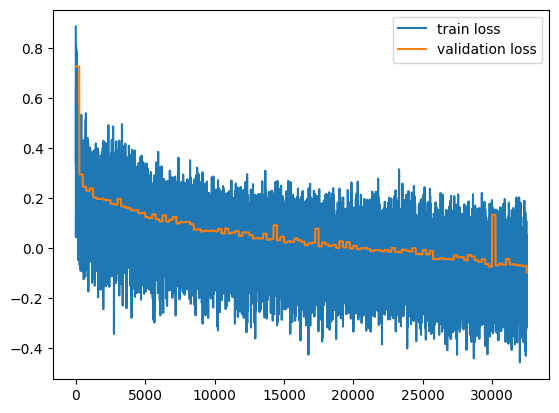

In [ ]:
plt.plot(jnp.log10(train_loss_values), label="train loss")
plt.plot(jnp.log10(validation_loss_values), label="validation loss")
plt.legend()
plt.show()

In [ ]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

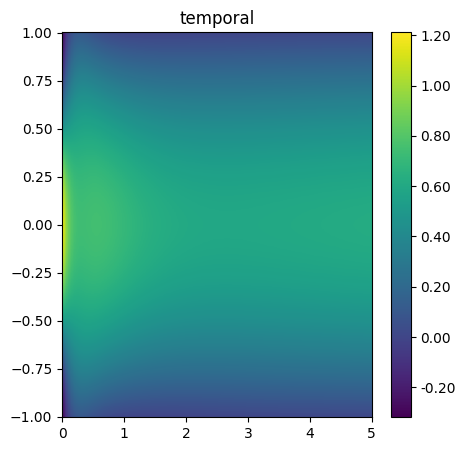

In [ ]:
u_est_spinn = lambda t, x: u_spinn(t, x, params_spinn["nn_params"])
# same subkey
jinns.data.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal", spinn=True)

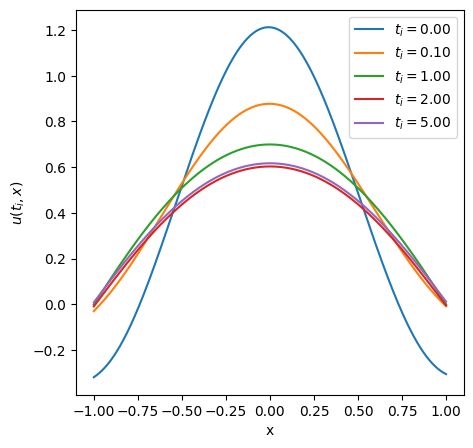

In [ ]:
time_slices = [0, 0.02, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax, figsize=(5, 5), spinn=True)